In [1]:
import io 
import os 
import re 
import shutil 
import string 
import tensorflow as tf 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                 untar = True, cache_dir='.',
                                 cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdbEr.txt', 'imdb.vocab']

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'urls_unsup.txt',
 'urls_neg.txt',
 'pos']

In [4]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [5]:
batch_size = 1024
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training',seed=seed
)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(),text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
embedding_layer = tf.keras.layers.Embedding(2000,6)

In [9]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.02729647,  0.03976381, -0.01038998,  0.02155064, -0.01243863,
        -0.03292196],
       [ 0.02492854,  0.0374717 ,  0.02562353,  0.03674522, -0.00642801,
        -0.0305626 ],
       [-0.04714821, -0.0323772 , -0.0446629 ,  0.0117672 ,  0.00472591,
         0.03190632]], dtype=float32)

In [10]:
result = embedding_layer(tf.constant([[0,1,2], [3,4,5]]))
result.shape

TensorShape([2, 3, 6])

In [11]:
def custom_standardization(input_data):
    lowercase =tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation), '')

vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length=sequence_length
)

text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
embedding_dim = 16

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size,embedding_dim,name='embedding'),
    GlobalAveragePooling1D(),
    Dense(16, activation = 'relu'),
    Dense(1)
])

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [14]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [15]:
history = model.fit(train_ds,
                   validation_data = val_ds,
                   epochs=20,
                   callbacks=[tensorboard_callback])

Epoch 1/20
20/20 [==============================] - 3s 105ms/step - loss: 0.6928 - accuracy: 0.5037 - val_loss: 0.6911 - val_accuracy: 0.4886
Epoch 2/20
20/20 [==============================] - 1s 70ms/step - loss: 0.6899 - accuracy: 0.5037 - val_loss: 0.6869 - val_accuracy: 0.4886
Epoch 3/20
20/20 [==============================] - 1s 70ms/step - loss: 0.6848 - accuracy: 0.5037 - val_loss: 0.6798 - val_accuracy: 0.4886
Epoch 4/20
20/20 [==============================] - 1s 70ms/step - loss: 0.6763 - accuracy: 0.5037 - val_loss: 0.6686 - val_accuracy: 0.4886
Epoch 5/20
20/20 [==============================] - 1s 69ms/step - loss: 0.6627 - accuracy: 0.5037 - val_loss: 0.6517 - val_accuracy: 0.4886
Epoch 6/20
20/20 [==============================] - 1s 70ms/step - loss: 0.6430 - accuracy: 0.5037 - val_loss: 0.6303 - val_accuracy: 0.4886
Epoch 7/20
20/20 [==============================] - 1s 76ms/step - loss: 0.6182 - accuracy: 0.5047 - val_loss: 0.6048 - val_accuracy: 0.5126
Epoch 8/20
2

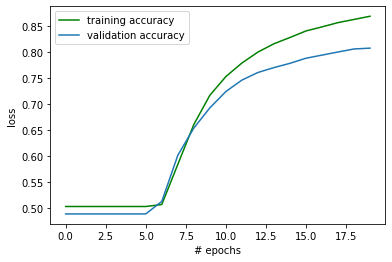

In [16]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'],'g',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

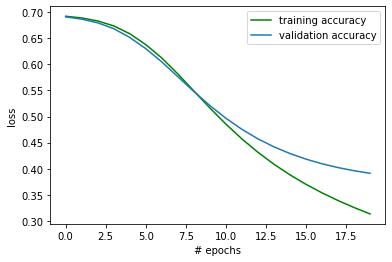

In [17]:
plt.plot(history.history['loss'],'g',label='training accuracy')
plt.plot(history.history['val_loss'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [19]:
out_v = io.open('vectors.tsv', 'w',encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index ==0:
        continue #skipping 0, its padding
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()